In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#! unzip '/content/drive/My Drive/fingers.zip' -d '/content/drive/My Drive/fingers'

## Loading Libraries

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
tf.config.experimental_run_functions_eagerly(True)

## Data Loading

In [4]:
train_dir = '/content/drive/My Drive/fingers/fingers/train'
test_dir = '/content/drive/My Drive/fingers/fingers/test'

In [5]:
train_images = os.listdir(train_dir)
test_images = os.listdir(test_dir)
train_images[0].split('.')[0].split('_')[1][0]

'2'

In [6]:
print("Total train Images : {}".format(len(train_images)))
print("Total test Images : {}".format(len(test_images)))

Total train Images : 4464
Total test Images : 3600


In [7]:
def load_data(images, train = True):
    X = []
    y = []
    for img in tqdm(images):
        label = int(img.split('.')[0].split('_')[1][0])
        if train:
            img_path = os.path.join(train_dir,img)
        else:
            img_path = os.path.join(test_dir,img)
        IMG = cv2.imread(img_path)
        IMG = np.array(IMG).astype('float32') / 255.
        X.append(IMG)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    return X,y
        

In [8]:
X_train, y_train = load_data(train_images, train = True)
X_test, y_test = load_data(test_images, train = False)

100%|██████████| 3600/3600 [13:29<00:00,  4.45it/s]


In [11]:
print(X_train.shape)
print(X_test.shape)

(4464, 128, 128, 3)
(3600, 128, 128, 3)


In [28]:
X = np.concatenate([X_train,X_test],axis = 0)
y = np.concatenate([y_train,y_test],axis = 0)

print("Shape of X :{}".format(X.shape))
print("Shape of y :{}".format(y.shape))

for i in range(6):
  print("No of images of class {} : {}".format(np.unique(y,return_counts=True)[0][i],np.unique(y,return_counts=True)[1][i] ))


Shape of X :(8064, 128, 128, 3)
Shape of y :(8064,)
No of images of class 0 : 1343
No of images of class 1 : 1331
No of images of class 2 : 1376
No of images of class 3 : 1325
No of images of class 4 : 1342
No of images of class 5 : 1347


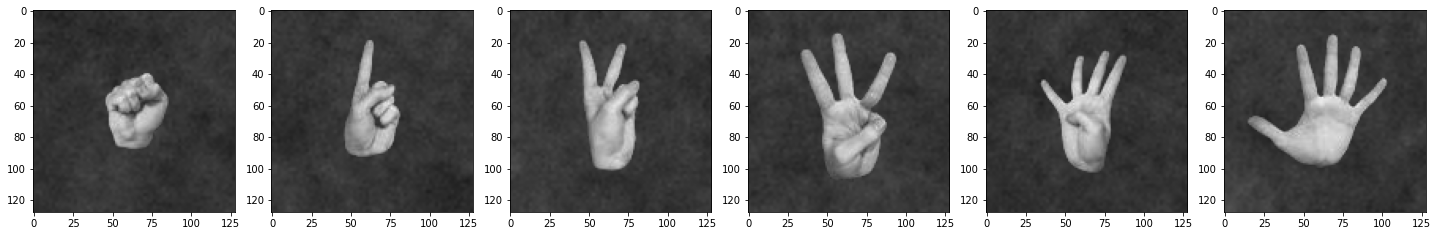

In [24]:
fig, ax = plt.subplots(1,6, figsize = (20,5))

for i in range(6):
  idx = np.where(y == i)[0][0]
  ax[i].imshow(X[idx])

plt.tight_layout()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 200)
print("X_train Size : {}".format(X_train.shape))
print("y_train Size : {}".format(y_train.shape))
print("X_test Size : {}".format(X_test.shape))
print("y_test Size : {}".format(y_test.shape))

X_train Size : (6451, 128, 128, 3)
y_train Size : (6451,)
X_test Size : (1613, 128, 128, 3)
y_test Size : (1613,)


In [38]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train, num_classes = 6)
y_test_one_hot = to_categorical(y_test, num_classes = 6)

## Model Building and Training

In [56]:
def build_model():
  in_img = layers.Input(shape = (128,128,3))
  d1 = layers.Conv2D(filters = 16, kernel_size = (3,3), strides = 1, activation = 'relu',padding = 'same')(in_img)
  d1 = layers.MaxPooling2D(pool_size = (2,2))(d1)     # 64x64x16

  d2 = layers.Conv2D(filters = 32, kernel_size = (3,3), strides = 1, activation = 'relu', padding = 'same')(d1)
  d2 = layers.MaxPooling2D(pool_size = (2,2))(d2) # 32x32x32

  d3 = layers.Conv2D(filters = 64, kernel_size = (3,3), strides = 1, activation = 'relu', padding = 'same')(d2)
  d3 = layers.MaxPooling2D(pool_size = (2,2))(d3) # 16x16x64
  
  d3 = layers.Flatten()(d3)

  d4 = layers.Dense(128, activation = 'relu')(d3)
  out = layers.Dense(6, activation = 'softmax')(d4)

  model = models.Model(inputs = in_img, outputs = out)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

In [59]:
model = build_model()
print(model.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 64)      

In [62]:
model.fit(X_train, y_train_one_hot, epochs = 10, batch_size=32, validation_split=0.15)

Epoch 1/10
  2/172 [..............................] - ETA: 4s - loss: 1.8289 - accuracy: 0.2344

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


172/172 [==============================] - 8s 46ms/step - loss: 0.1685 - accuracy: 0.9475 - val_loss: 0.0132 - val_accuracy: 0.9938
Epoch 2/10
172/172 [==============================] - 8s 44ms/step - loss: 0.0104 - accuracy: 0.9976 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/10
172/172 [==============================] - 8s 44ms/step - loss: 2.1645e-04 - accuracy: 1.0000 - val_loss: 2.0537e-04 - val_accuracy: 1.0000
Epoch 4/10
172/172 [==============================] - 8s 44ms/step - loss: 6.9343e-05 - accuracy: 1.0000 - val_loss: 1.2862e-04 - val_accuracy: 1.0000
Epoch 5/10
172/172 [==============================] - 8s 45ms/step - loss: 3.9356e-05 - accuracy: 1.0000 - val_loss: 9.9754e-05 - val_accuracy: 1.0000
Epoch 6/10
172/172 [==============================] - 8s 44ms/step - loss: 2.7833e-05 - accuracy: 1.0000 - val_loss: 5.6406e-05 - val_accuracy: 1.0000
Epoch 7/10
172/172 [==============================] - 8s 44ms/step - loss: 1.9957e-05 - accuracy: 1.0000 - val_loss: 4.50

In [63]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [71]:
y_pred_final = np.argmax(y_pred,axis = 1)
accuracy = np.sum(y_pred_final == y_test) / y_test.shape[0]
print("Test Accuracy : {}%".format(accuracy*100))

Test Accuracy : 100.0%


In [72]:
model.save('/content/drive/My Drive/fingers/fingers.h5')

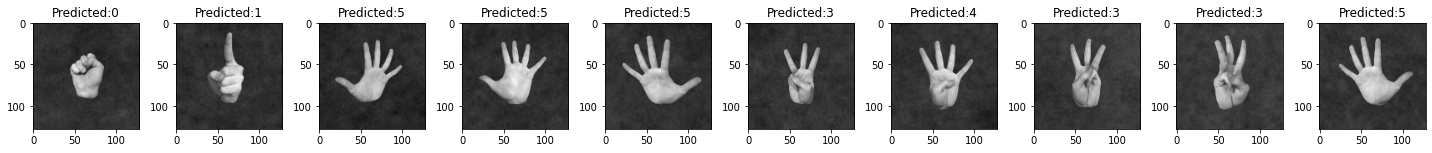

In [81]:
fig ,ax = plt.subplots(1,10, figsize = (20,10))
for i in range(10):
  ax[i].imshow(X_test[i])
  ax[i].set_title("Predicted:{}".format(y_pred_final[i]))
plt.tight_layout()